### Introduction

PINNs are a class of neural networks for solving partial differential equations. They are trained to minimize the residual of the differential equation, and the boundary and initial conditions. This is done by defining a loss function that is the sum of the mean squared error of the differential equation and the boundary and initial conditions. The loss function is minimized using gradient descent.


Reference: https://www.youtube.com/watch?v=LQ33-GeD-4Y

Let us assume our true function is:

$$u(x) = e^{ax} + x$$

We have:

$$\frac{du}{dx} = ae^{ax} + 1$$

$$\frac{d^2u}{dx^2} = a^2e^{ax}$$

We can create a differential equation from this:

$$\frac{d^2u}{dx^2} - a\frac{du}{dx} = a$$

We can also create a boundary condition from this:

$$u(0) = 1$$
$$u(1) = e^a + 1$$


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x_lin = torch.linspace(0, 1, 100)
a = 2
u_true = torch.e**(a*x_lin) +   x_lin

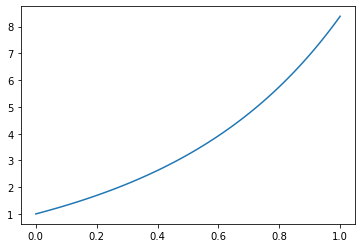

In [3]:
plt.plot(x_lin, u_true)

In [4]:
class MLP(nn.Module):
    def __init__(self, n_input=1, n_hidden=5, n_output=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
u_model = MLP(n_hidden=20).to(device)
u_model

MLP(
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [7]:
# Let us compute du/dx for any x vector

x_vec = torch.randn(10, 1, requires_grad=True).to(device)
u_vec = u_model(x_vec)
print(u_vec)

tensor([[0.1620],
        [0.1934],
        [0.0714],
        [0.0571],
        [0.1903],
        [0.1520],
        [0.1660],
        [0.0063],
        [0.0372],
        [0.0696]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [8]:
du_dx  = torch.autograd.grad(u_vec, # Whose gradient we want
                            x_vec, # WRT what we want the gradient
                            torch.ones_like(u_vec), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again

In [9]:
du_dx

tensor([[-0.0515],
        [-0.0306],
        [-0.1101],
        [-0.1171],
        [-0.0325],
        [-0.0587],
        [-0.0487],
        [-0.1360],
        [-0.1257],
        [-0.1111]], device='cuda:0', grad_fn=<MmBackward0>)

In [10]:
# Now, let us compute d2u/dx2 for any x vector

x_vec = torch.randn(10, 1, requires_grad=True).to(device)
u_vec = u_model(x_vec)
du_dx  = torch.autograd.grad(u_vec, # Whose gradient we want
                            x_vec, # WRT what we want the gradient
                            torch.ones_like(u_vec), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again

d2u_dx2  = torch.autograd.grad(du_dx, # Whose gradient we want
                            x_vec, # WRT what we want the gradient
                            torch.ones_like(du_dx), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again


In [11]:
d2u_dx2

tensor([[-0.0410],
        [-0.0573],
        [-0.0434],
        [-0.0512],
        [ 0.0402],
        [-0.0564],
        [ 0.0408],
        [-0.0561],
        [-0.0580],
        [-0.0543]], device='cuda:0', grad_fn=<MmBackward0>)

In [12]:
# PDE loss

def pde_loss(model, x):
    u = model(x)
    du_dx = torch.autograd.grad(u, # Whose gradient we want
                            x, # WRT what we want the gradient
                            torch.ones_like(u), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again
    d2u_dx2 = torch.autograd.grad(du_dx, # Whose gradient we want
                            x, # WRT what we want the gradient
                            torch.ones_like(du_dx), # Shape of the gradient
                            create_graph=True)[0] # We want to differentiate again
    
    # Our PDE is d2u/dx2 -a*du/dx = a
    # Loss = (d2u/dx2 -a*du/dx - a)**2
    loss = (d2u_dx2 - a*du_dx - a)**2
    return loss.mean()
    

In [13]:
# Boundary loss
def boundary_loss(model):
    # Boundary condition u(0) = 1
    x = torch.tensor([[0.0]]).to(device)
    u = model(x)
    loss = (u - 1)**2
    
    # Boundary condition u(1) = e^a + 1
    x = torch.tensor([[1.0]]).to(device)
    u = model(x)
    loss += (u - torch.e**(a) - 1)**2
    return loss.mean()

In [14]:
# Training loop
u_model = MLP(n_hidden=30).to(device)

optimizer = torch.optim.Adam(u_model.parameters(), lr=0.001)

for epoch in range(5000):
    optimizer.zero_grad()
    x_vec = torch.rand((400, 1), requires_grad=True).to(device)
    loss = pde_loss(u_model, x_vec) + boundary_loss(u_model)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch: {}, Loss: {:.4f}".format(epoch, loss.item()))


    

Epoch: 0, Loss: 76.9179
Epoch: 50, Loss: 44.1352
Epoch: 100, Loss: 32.6026
Epoch: 150, Loss: 29.2667
Epoch: 200, Loss: 26.7229
Epoch: 250, Loss: 25.0849
Epoch: 300, Loss: 21.3763
Epoch: 350, Loss: 15.6775
Epoch: 400, Loss: 9.4585
Epoch: 450, Loss: 5.4534
Epoch: 500, Loss: 2.9488
Epoch: 550, Loss: 1.8614
Epoch: 600, Loss: 1.1479
Epoch: 650, Loss: 0.7941
Epoch: 700, Loss: 0.5778
Epoch: 750, Loss: 0.4576
Epoch: 800, Loss: 0.4216
Epoch: 850, Loss: 0.3251
Epoch: 900, Loss: 0.2402
Epoch: 950, Loss: 0.2836
Epoch: 1000, Loss: 0.1607
Epoch: 1050, Loss: 0.1918
Epoch: 1100, Loss: 0.1569
Epoch: 1150, Loss: 0.1289
Epoch: 1200, Loss: 0.1106
Epoch: 1250, Loss: 0.0871
Epoch: 1300, Loss: 0.0962
Epoch: 1350, Loss: 0.0702
Epoch: 1400, Loss: 0.0816
Epoch: 1450, Loss: 0.0658
Epoch: 1500, Loss: 0.0581
Epoch: 1550, Loss: 0.0451
Epoch: 1600, Loss: 0.0355
Epoch: 1650, Loss: 0.0454
Epoch: 1700, Loss: 0.0382
Epoch: 1750, Loss: 0.0327
Epoch: 1800, Loss: 0.0364
Epoch: 1850, Loss: 0.0294
Epoch: 1900, Loss: 0.0345
E

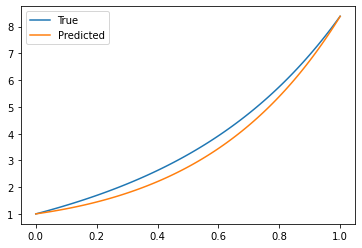

In [15]:
# Plotting the results
x_lin = torch.linspace(0, 1, 100).to(device)
u_true = torch.e**(a*x_lin) +   x_lin
u_pred = u_model(x_lin.unsqueeze(1)).cpu().detach()

plt.plot(x_lin.cpu(), u_true.cpu(), label="True")
plt.plot(x_lin.cpu(), u_pred, label="Predicted")
plt.legend()